In [21]:
import torch
import os
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [22]:
print(os.getcwd())

project_dir = '/workspace'
image_file = json.load(open(f'{project_dir}/datasets/vg/image_data.json'))
vocab_file = json.load(open(f'{project_dir}/datasets/vg/VG-SGG-dicts.json'))
data_file = h5py.File(f'{project_dir}/datasets/vg/VG-SGG.h5', 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

/workspace/visualization


In [3]:
print(os.listdir(os.getcwd()))

!cd .. && python setup.py build develop install

['.ipynb_checkpoints', '3.visualize_custom_SGDet.ipynb', '1.visualize_PredCls_and_SGCls.ipynb', '2.visualize_SGDet.ipynb']
running build
running build_py
running build_ext
building 'maskrcnn_benchmark._C' extension
Emitting ninja build file /workspace/build/temp.linux-x86_64-3.8/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/11] c++ -MMD -MF /workspace/build/temp.linux-x86_64-3.8/workspace/maskrcnn_benchmark/csrc/cpu/ROIAlign_cpu.o.d -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DWITH_CUDA -I/workspace/maskrcnn_benchmark/csrc -I/opt/conda/lib/python3.8/site-packages/torch/include -I/opt/conda/lib/python3.8/site-packages/torch/include/torch/csrc/api/include -I/opt/conda/lib/python3.8/site-packages/torch/include/TH -I/opt/conda/lib/python3.8/site-packages/torch/include/THC -I/usr/local/cuda/include -I/op

In [4]:
# load detected results
!cd ..
detected_origin_path = f'{project_dir}/datasets/vg/checkpoints/checkpoint_causal_motif_sgdet/inference/VG_stanford_filtered_with_attribute_test/'
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [51]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.30):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = prediction.bbox
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    pred_scores = prediction.get_field('pred_scores').tolist()
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    # thres = 0.1
    mask = pred_rel_score > thres
    pred_rel_score = pred_rel_score[mask]
    pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label

In [52]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)



def print_list(name, input_list, scores):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i].item()))
    
def draw_image(img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = pred_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
    if print_img:
        print('*' * 50)
        print_list('gt_boxes', labels, None)
        print('*' * 50)
        print_list('gt_rels', gt_rels, None)
        print('*' * 50)
    print_list('pred_labels', pred_labels, pred_rel_score)
    print('*' * 50)
    print_list('pred_rels', pred_rels, pred_rel_score)
    print('*' * 50)
    
    return None

In [53]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
        draw_image(*get_info_by_idx(select_idx, detected_origin_result))
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(f'Image {cand_idx}:')
        img_path, boxes, labels, pred_labels, pred_scores, gt_rels, pred_rels, pred_rel_score, pred_rel_label = get_info_by_idx(cand_idx, detected_origin_result)
        draw_image(img_path=img_path, boxes=boxes, labels=labels, pred_labels=pred_labels, pred_scores=pred_scores, gt_rels=gt_rels, pred_rels=pred_rels, pred_rel_score=pred_rel_score, pred_rel_label=pred_rel_label, print_img=True)

1


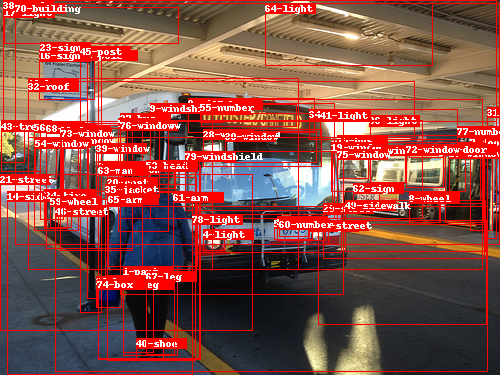

**************************************************
gt_boxes 0: 0-bag
gt_boxes 1: 1-bus
gt_boxes 2: 2-bus
gt_boxes 3: 3-coat
gt_boxes 4: 4-pant
gt_boxes 5: 5-pole
gt_boxes 6: 6-roof
gt_boxes 7: 7-sidewalk
gt_boxes 8: 8-sign
gt_boxes 9: 9-window
gt_boxes 10: 10-woman
**************************************************
gt_rels 0: ('2-bus', 'under', '6-roof')
gt_rels 1: ('10-woman', 'near', '2-bus')
gt_rels 2: ('9-window', 'on', '2-bus')
gt_rels 3: ('10-woman', 'wearing', '3-coat')
**************************************************
pred_labels 0: 0-sign; score: 0.3713594377040863
pred_labels 1: 1-pant; score: 0.3675380051136017
pred_labels 2: 2-woman; score: 0.3021714389324188
pred_labels 3: 3-tire; score: 0.30860841274261475
pred_labels 4: 4-light; score: 0.307725191116333
pred_labels 5: 5-hair; score: 0.40503737330436707
pred_labels 6: 6-pole; score: 0.3006044030189514
pred_labels 7: 7-door; score: 0.3623998165130615
pred_labels 8: 8-wheel; score: 0.3062223792076111
pred_labels 9: 9-winds

In [54]:
# show_all(start_idx=3, length=1)
show_selected([1])
# show_selected([1, 2, 3, 4, 5, 6, 7, 8, 9])